# PRÁCTICA DE IMÁGEN

## DIFERENCIA DE ACCURACY ENTRE UNA CNN Y UN MODELO DE TRANSFER LEARNING

**María Ruiz de Castroviejo y Sergio Rincón**

Los datos se obtienen de: https://www.kaggle.com/slothkong/10-monkey-species?select=monkey_labels.txt

**Importamos las librerías:**

In [1]:
#pip install imgaug

In [2]:
#pip install mlxtend

In [3]:
# pip install imgaug
# pip install mlxtend  

import os
import cv2
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from pathlib import Path
import skimage
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras import backend as K
import tensorflow as tf


color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format="svg"

**Fijamos la semilla y cargamos los datos:**

In [4]:
os.environ['PYTHONHASHSEED'] = '0'
seed=123
np.random.seed(seed)

tf.random.set_seed(seed)            # Establecer la semilla aleatoria en tensorflow a nivel de gráfico
aug.seed(seed)                      # Hacer determinista la secuencia de aumento

labels_path = Path('./monkey_labels.txt')

**Guardamos en un dataframe los distintos tipos de monos que vamos a intentar clasificar:**

In [5]:
labels_info = []

# leemos el fichero
lines = labels_path.read_text().strip().splitlines()[1:]
for line in lines:
    line = line.split(',')
    line = [x.strip(' \n\t\r') for x in line]
    line[3], line[4] = int(line[3]), int(line[4])
    line = tuple(line)
    labels_info.append(line)
    
# Los pasamos a dataFrame
labels_info = pd.DataFrame(labels_info, columns=['Label', 'Latin Name', 'Common Name', 'Train Images', 'Validation Images'], index=None)
labels_info.head(10)

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata,mantled_howler,131,26
1,n1,erythrocebus_patas,patas_monkey,139,28
2,n2,cacajao_calvus,bald_uakari,137,27
3,n3,macaca_fuscata,japanese_macaque,152,30
4,n4,cebuella_pygmea,pygmy_marmoset,131,26
5,n5,cebus_capucinus,white_headed_capuchin,141,28
6,n6,mico_argentatus,silvery_marmoset,132,26
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [6]:
print('Entrenamos con:',labels_info['Train Images'].sum(),' imagenes')

Entrenamos con: 1370  imagenes


In [7]:
print('Validamos con ', labels_info['Validation Images'].sum(),'imagenes')

Validamos con  272 imagenes


Observamos en la siguiente gráfica que vamos a tratar de clasificar 10 tipos de monos distintos y los set de entrenamiento y validación que vamos a utilizar:

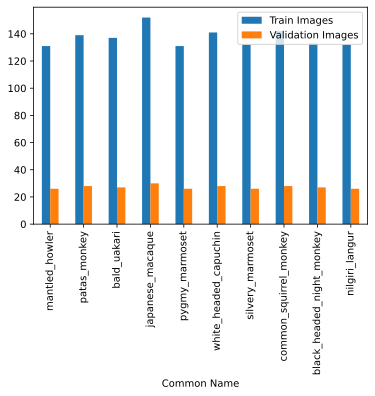

In [8]:
labels_info.plot.bar(x='Common Name', y=['Train Images', 'Validation Images'])

Observamos que nuestro set de entrenamiento y de validación no son muy grandes, problablemente habrá que introducir alguna técnica de para evitar el overfitting como DATA AUGMENTATION o TRANSFER LEARNING

**ANÁLISIS DE IMAGENES PRELIMINAR**

Mostramos imagenes de los distintos monos que queremos analizar:

white_headed_capuchin:


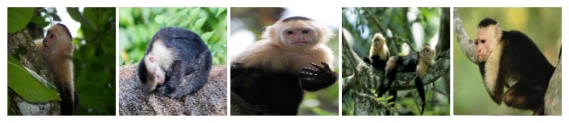

In [9]:
from glob import glob
print("white_headed_capuchin:")#Indicamos que tipo de mono vamos a ver imagenes
multipleImages = glob('./training/n5/**')#aqui introducimos el tipo de mono del que queremos ver imagenes
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:5]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

## MODELO MACHINE LEARNING: CNN

In [10]:
train_dir = Path('./training/')
test_dir = Path('./validation/')

In [11]:
from keras.preprocessing.image import ImageDataGenerator

Indicamos los parámetros de entrada necesarios para generar nuestro set de imagenes de entrenamiento y validación (imagenes de 150x150)

Seleccionamos un tamaño de batch de 64,es decir, trabajaremos con 64 muestras antes de actualizar los parámetros internos del modelo.

In [12]:
height = 150
width = 150
batch_size = 64
seed = 100

Generamos nuestro training data con 1098 imagenes de entrenamiento:

In [13]:
# Training generator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
    class_mode='categorical')

Found 1098 images belonging to 10 classes.


Generamos nuestro validation set con 272 imagenes:

In [14]:
# Test generator
test_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    seed=seed,
    shuffle=False,
    class_mode='categorical')

Found 272 images belonging to 10 classes.


In [15]:
train_num = train_generator.samples
validation_num = validation_generator.samples 

Definimos la red convulucional:

HIDDEN LAYERS

1. Primera hiden layer: tomará las imagenes(150x150 y 3 canales, es decir, a color) como input. El mumero de filtros aplicados en esta primera convolución es 32 y de tamaño 3x3(kernel size), es decir, un tensor de 32x3x3. Utilizamos un stride=2 para reducir el tamaño del output y analizar las imagenes un poco más rapido. Finalmente se usará la función Relu tras la aplicación del tensor.
    + Tras ello aplicaremos una capa de Batch Normalization: estas capas buscan un preprocesado de la imagen. Las redes neuronales trabajan más rápido si los datos de entrada se mantienen similares entre capa y capa. Para ello se utiliza el BatchNormalization, que ayudará a que nuestra CNN trabaje a mayor velocidad.
    

2. Segunda hidden layer + Batch Normalization: 32x3x3 con función Relu.

3. Tercera hidden layer+ Batch Normalization: 16x3x3 con función Relu.

4. Cuarta hidden layer+ Batch Normalization: 8x3x3 con función Relu.

5. Flatten layer: 512x1x1. el contenido de los feature maps obtenidos gracias a las anteriores capas se convierte en un Tensor unidimensional que se puede utilizar en las capas Dense. Añadimos la duncion de activación Relu tras aplicar el tensor unidimensional

CLASSIFICATION: DENSE LAYER

6. Aplicaremos dos capas densas al final y como vamos a clasificar 10 tipos de monos, usaremos una última capa con 10 salidas y una funcion de activación 'Softmax'.

In [16]:
def get_net(num_classes):
    from keras.models import Sequential
    from keras.layers import Conv2D, Activation, BatchNormalization, GlobalAvgPool2D, MaxPooling2D, Dropout

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), strides=2))
    model.add(Activation('relu'))

    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), strides=2))
    model.add(Activation('relu'))

    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3)))
    model.add(Activation('relu'))
    

    model.add(BatchNormalization())
    model.add(Conv2D(8, (3, 3)))
    model.add(Activation('relu'))


    model.add(Flatten())
    model.add(Dense(32, Activation('relu')))
    model.add(Dense(10, Activation('softmax')))

    return model

num_classes = 10
net = get_net(num_classes)
net.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 74, 74, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 36, 36, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 16)        4

Como podemos observar nuestro output de 32x32x8 se convierte en un vector unidimensional de 8192 antes de entrar en los últimos pasos de capas densas con su funcion de activación.

Ahora entrenamos nuestra red convolucional con 10 epochs (el modelo está entrenado en local):

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath=("monkey.h5f")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# = EarlyStopping(monitor='val_acc', patience=15)
callbacks_list = [checkpoint]#, stopper]

epochs = 10

history = net.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=train_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=callbacks_list, 
                              verbose = 1
                             )

C:\Users\sergi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
17/17 [==============================] - 52s 3s/step - loss: 2.6203 - acc: 0.1223 - val_loss: 2.2917 - val_acc: 0.1172

Epoch 00001: val_acc improved from -inf to 0.11719, saving model to monkey.h5f


INFO:tensorflow:Assets written to: monkey.h5f\assets


INFO:tensorflow:Assets written to: monkey.h5f\assets


Epoch 2/10
17/17 [==============================] - 45s 3s/step - loss: 2.0846 - acc: 0.2249 - val_loss: 2.2973 - val_acc: 0.0859

Epoch 00002: val_acc did not improve from 0.11719
Epoch 3/10
17/17 [==============================] - 46s 3s/step - loss: 2.0531 - acc: 0.2445 - val_loss: 2.2701 - val_acc: 0.1250

Epoch 00003: val_acc improved from 0.11719 to 0.12500, saving model to monkey.h5f


INFO:tensorflow:Assets written to: monkey.h5f\assets


INFO:tensorflow:Assets written to: monkey.h5f\assets


Epoch 4/10
17/17 [==============================] - 44s 3s/step - loss: 2.0326 - acc: 0.2806 - val_loss: 2.2524 - val_acc: 0.1914

Epoch 00004: val_acc improved from 0.12500 to 0.19141, saving model to monkey.h5f


INFO:tensorflow:Assets written to: monkey.h5f\assets


INFO:tensorflow:Assets written to: monkey.h5f\assets


Epoch 5/10
17/17 [==============================] - 45s 3s/step - loss: 1.9987 - acc: 0.2800 - val_loss: 2.2292 - val_acc: 0.1836

Epoch 00005: val_acc did not improve from 0.19141
Epoch 6/10
17/17 [==============================] - 46s 3s/step - loss: 1.9636 - acc: 0.2629 - val_loss: 2.2590 - val_acc: 0.1445

Epoch 00006: val_acc did not improve from 0.19141
Epoch 7/10
17/17 [==============================] - 59s 4s/step - loss: 1.8747 - acc: 0.3164 - val_loss: 2.2714 - val_acc: 0.1484

Epoch 00007: val_acc did not improve from 0.19141
Epoch 8/10
17/17 [==============================] - 73s 4s/step - loss: 1.9286 - acc: 0.2864 - val_loss: 2.1853 - val_acc: 0.1797

Epoch 00008: val_acc did not improve from 0.19141
Epoch 9/10
17/17 [==============================] - 74s 4s/step - loss: 1.8901 - acc: 0.3092 - val_loss: 2.3552 - val_acc: 0.1289

Epoch 00009: val_acc did not improve from 0.19141
Epoch 10/10
17/17 [==============================] - 59s 3s/step - loss: 1.8373 - acc: 0.3202 -

Podemos apreciar que el accuracy alcanzado con 10 epochs no es muy bueno, probablemente cambiando la estructura de la red convulucional, añadiendo más capas o realizando más epochs mejoraría el resultado a decrimento de tiempo de computación. 

Que el accuracy en training con 10 epochs sea del 0.32 quiere decir que acertaremos en la clasificación de los monos un 32% de las veces, lo que no es un valor muy fiable y menos cuando lo pruebas con imagenes de test.  

Para mejorar este accuracy proponemos realizar un modelo de transfer learning con data augmantation. Ya que nuestro modelo no entrena con suficientes imagenes y de ahí que no obtenga resultados muy satisfactorios.

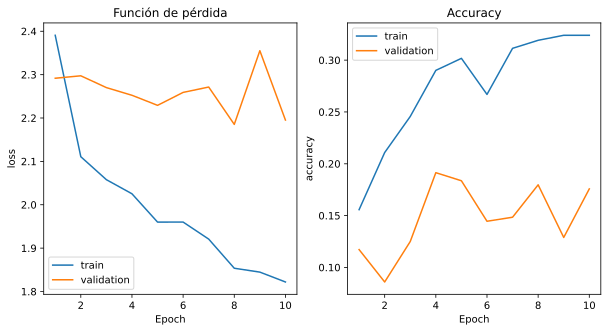

In [18]:
def visualized_history(history):
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    f,ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].plot(epochs, loss)
    ax[0].plot(epochs, val_loss)
    ax[0].set_title("Función de pérdida")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("loss")
    ax[0].legend(['train', 'validation'])

    ax[1].plot(epochs, acc)
    ax[1].plot(epochs, val_acc)
    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("accuracy")
    ax[1].legend(['train', 'validation'])
    
    plt.show()
    
visualized_history(history)

En estas gráficas confirmamos lo explicado anteriormente. Si exportaramos el modelo realizado en training y lo probamos con las imagenes de test el accuracy sería muy malo.

No es un modelo que pudieramos poner en producción con solo 10 epochs o con tan pocas imagenes de entrenamiento.

## MODELO APLICANDO DATA AUGMENTATION Y TRANSFER LEARNING

Creamos un diccionario con el número de clases; como son 10 llegamos hasta 9 y creamos otro también para cada nombre de cada clase:

In [19]:
training_data = Path('./training/') 
validation_data = Path('./validation/') 

In [20]:
labels_dict= {'n0':0, 'n1':1, 'n2':2, 'n3':3, 'n4':4, 'n5':5, 'n6':6, 'n7':7, 'n8':8, 'n9':9}

names_dict = dict(zip(labels_dict.values(), labels_info["Common Name"]))
print(names_dict)

{0: 'mantled_howler', 1: 'patas_monkey', 2: 'bald_uakari', 3: 'japanese_macaque', 4: 'pygmy_marmoset', 5: 'white_headed_capuchin', 6: 'silvery_marmoset', 7: 'common_squirrel_monkey', 8: 'black_headed_night_monkey', 9: 'nilgiri_langur'}


- **Generamos la muestra de Train:**

In [21]:
# Entrenamiento
train_df = []
for folder in os.listdir(training_data):
    
    imgs_path = training_data / folder          # Carpeta de imágenes
    imgs = sorted(imgs_path.glob('*.jpg'))      # Imágenes del directorio
    
    for img_name in imgs:
        train_df.append((str(img_name), labels_dict[folder]))


train_df = pd.DataFrame(train_df, columns=['image', 'label'], index=None)
train_df = train_df.sample(frac=1.).reset_index(drop=True)                     # Generamos muestra aleatoria

- **Generamos la muestra de Test:**

In [22]:
# Validación
valid_df = []
for folder in os.listdir(validation_data):
    imgs_path = validation_data / folder
    imgs = sorted(imgs_path.glob('*.jpg'))
    for img_name in imgs:
        valid_df.append((str(img_name), labels_dict[folder]))

        
valid_df = pd.DataFrame(valid_df, columns=['image', 'label'], index=None)
valid_df = valid_df.sample(frac=1.).reset_index(drop=True)                 # Generamos muestra aleatoria

In [23]:
print("Número de muestras en el fichero de Train: ", len(train_df))
print("Número de muestras en el fichero de Test: ", len(valid_df))

print("\n",train_df.head(), "\n")
print("=================================================================\n")
print("\n", valid_df.head())

Número de muestras en el fichero de Train:  1096
Número de muestras en el fichero de Test:  272

                    image  label
0  training\n5\n5066.jpg      5
1   training\n8\n808.jpg      8
2  training\n3\n3165.jpg      3
3  training\n9\n9118.jpg      9
4  training\n9\n9017.jpg      9 



                      image  label
0  validation\n7\n7016.jpg      7
1   validation\n4\n408.jpg      4
2   validation\n6\n616.jpg      6
3   validation\n1\n114.jpg      1
4   validation\n3\n306.jpg      3


- **Constantes que se van a utilizar:**

In [24]:
# Dimensiones de las imágenes y 3 canales que indica que son imagenes a color
img_rows, img_cols, img_channels = 224,224,3

# Batch size de la muestra de entrenamiento
batch_size=8

# Número de clases del dataset
nb_classes=10

# Data Augmentation

Cuando entrenamos redes convulucionales con muy pocas imagenes de entrenamiento como es nuestro caso es muy fácil caer en overfitting, en nuestro caso observavamos que con 10 epochs el modelo de entrenamiento tiene un accuracy del 50% que presumiblemente si aumentamos las epochs mejoraría el accuaracy. En cambio, en las gráficas observavamos que se producía overfitting, ya que no era un modelo exportable en el caso de test donde el modelo actuaba muy mal.

La técnica de Data augmentation evitará que caigamos en overfitting aumentando las imagenes de muestra con transformaciones aleatorias.De esta manera, nuestro modelo nunca verá más de dos imagenes iguales, esto permitirá generalizar mejor al modelo.

Cuantos más datos proporcionemos, mejor será el rendimiento (hasta llegar a un límite). Por eso es imporante el aumento de datos. Usaremos imgaug para aumentar nuestras imágenes:

In [25]:
# Secuencia de aumentos para cada imagen
seq = iaa.OneOf([
    iaa.Fliplr(),                 # Volteos
    iaa.Affine(rotate=20),        # Rotación
    iaa.Multiply((1.2, 1.5))])    # Brillo aleatorio

# Data Generator

In [26]:
def data_generator(data, batch_size, is_validation_data=False):
    n = len(data)                                     # Número de observaciones
    nb_batches = int(np.ceil(n/batch_size))

    indices = np.arange(n)
    
    # Concatenamos los datos y las etiquetas
    batch_data = np.zeros((batch_size, img_rows, img_cols, img_channels), dtype=np.float32)
    batch_labels = np.zeros((batch_size, nb_classes), dtype=np.float32)
    
    while True:
        if not is_validation_data:
            np.random.shuffle(indices)
            
        for i in range(nb_batches):
            next_batch_indices = indices[i*batch_size:(i+1)*batch_size]
            
            for j, idx in enumerate(next_batch_indices):
                img = cv2.imread(data.iloc[idx]["image"])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                label = data.iloc[idx]["label"]
                
                if not is_validation_data:
                    img = seq.augment_image(img)
                
                img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
                batch_data[j] = img
                batch_labels[j] = to_categorical(label,num_classes=nb_classes)
            
            batch_data = preprocess_input(batch_data)
            yield batch_data, batch_labels

In [27]:
# Generador de datos para la muestra de entrenamiento
train_data_gen = data_generator(train_df, batch_size)

# Generador de datos para la muestra de validación
valid_data_gen = data_generator(valid_df, batch_size, is_validation_data=True)

# Modelling

Las redes preentrenadas con grandes cantidades de datos mejoran el accuracy de los modelos cuando estos trabajan con pequelos datasets de datos como es nuestro caso.


Elegimos la red conv VGG16 entreada en ImageNet como red base para hacer el aprendizajepor transferencia. Este tipo de redes convolucionales muy profundas se utilizan mucho para el reconocimiento de imágenes a gran escala:

In [28]:
# Modelo base
def get_base_model():
    base_model = VGG16(input_shape=(img_rows, img_cols, img_channels), weights='imagenet', include_top=True)#Incluimos un clasificador densamente conectado
    return base_model

Definimos la red convulucional:

HIDDEN LAYERS

Primeras hidden layer: estan compuesta por la misma estructura de dos tensores de 224x224x64 después se aplica una capa de pooling que reduce a la mitad las dimensiones del input en la siguiente capa. La funcion de activación que se utiliza en estas capas es Softmax.

Siguientes hidden layer: estan compuesta por la misma estructura de tres tensores que empiezan con una dimensión de 56x56x128 después se aplica una capa de pooling que reduce a la mitad las dimensiones del input en la siguiente capa. La funcion de activación que se utiliza en estas capas es Softmax.


Flatten layer: 512x1x1. el contenido de los feature maps obtenidos gracias a las anteriores capas se convierte en un Tensor unidimensional que se puede utilizar en las capas Dense. Añadimos la duncion de activación Relu tras aplicar el tensor unidimensional

CLASSIFICATION: DENSE LAYER

Con la técnica de flatten pasamos del poolin de 5x5x512 a un vector unidimensional de 25088.

Aplicamos tres capas densas donde todas las neuronas estas conectadas entre sí hasta llegar a un vector unidimensional de 10 que clasificará las imagenes.

En estas capas densas observamos que se utiliza la técnica de DropOut con una probabilidad de 0.7, esta técnica restringe la adaptación de la red a los datos en el momento del entrenamiento para evitar el overfitting. La probabilidad de 0.7 representa el porcentaje de neuronas cuya salida se reducirá
al pasar a la siguiente capa. Esto reduce efectivamente el número de parámetros y simplifica el modelo que se está ajustando.

In [29]:
base_model = get_base_model()

# Obtenemos la salida de la penúltima capa densa
base_model_output = base_model.layers[-2].output

# Añadimos nuevas capas
x = Dropout(0.7,name='drop2')(base_model_output) #Destacar que utilizamos la técnica de dropout para evitar overfitting
output = Dense(10, activation='softmax', name='fc3')(x)

# Definimos un nuevo modelo
model = Model(base_model.input, output)

# Congelamos todas las capas del modelo base
for layer in base_model.layers[:-1]:
    layer.trainable=False

# Modelo final
optimizer = RMSprop(0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [30]:
# Carga los pesos de la mejor iteración una vez que finaliza el entrenamiento
es = EarlyStopping(patience=10, restore_best_weights=True)

# Checkpoint pra guardar el modelo
chkpt = ModelCheckpoint(filepath="model1", save_best_only=True)

nb_train_steps = int(np.ceil(len(train_df)/batch_size))
nb_valid_steps = int(np.ceil(len(valid_df)/batch_size))

# Número de epochs: con 3 ya conseguimos una precisiónmuy buena
nb_epochs=3

Eligimos 3 epochs y observamos que con un modelo de transfer Learning entrenado con la red VG16 en la primera epoch ya obtenemos un accuracy en el training que mejora considerablemente nuestra primera red convulucional.

Se aprecia de forma drástica la mejora de un modelo a otro.

In [31]:
# Entrenamos el modelo
history1 = model.fit_generator(train_data_gen, 
                              epochs=nb_epochs, 
                              steps_per_epoch=nb_train_steps, 
                              validation_data=valid_data_gen, 
                              validation_steps=nb_valid_steps,
                              callbacks=[es,chkpt])


C:\Users\sergi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
137/137 [==============================] - 306s 2s/step - loss: 2.6182 - accuracy: 0.5220 - val_loss: 0.0751 - val_accuracy: 0.9632
INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 2/3
137/137 [==============================] - 326s 2s/step - loss: 0.3421 - accuracy: 0.9192 - val_loss: 0.0855 - val_accuracy: 0.9669
Epoch 3/3
137/137 [==============================] - 342s 2s/step - loss: 0.2552 - accuracy: 0.9357 - val_loss: 0.0165 - val_accuracy: 1.0000
INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


- **Función de pérdida y precisión del modelo en función de los epoch:**

In [32]:
# Precisión
train_acc = history1.history['accuracy']
valid_acc = history1.history['val_accuracy']

# Función de pérdida
train_loss = history1.history['loss']
valid_loss = history1.history['val_loss']

# Número de entradas
xvalues = np.arange(len(train_acc))

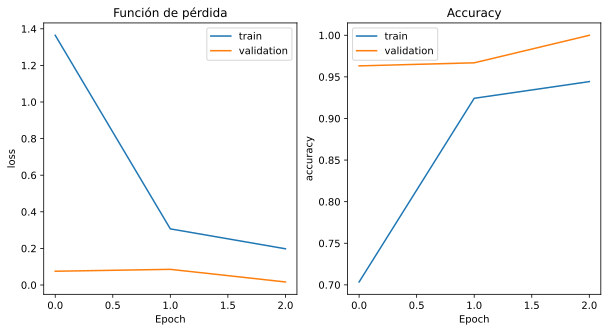

In [33]:
# Gráfico
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Función de pérdida")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues, train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()

Observamos que con transfer Learning + Data Augmentation + DropOut tambiénm evitamos el overfitting y obtenemos un accuracy muy aceptable 93,57% con tan solo 3 epochs que mejora en gran medida el primer modelo provado de una CNN.